In [10]:
# read in libraries
import tensorflow as tf
from tensorflow.keras import backend, models, layers, optimizers
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
from tensorflow.keras.models import Model
from shutil import copyfile
import scipy
np.random.seed(42)

In [12]:
size = 127
data_dir = "C:/Users/asus/Documents/Bachelor Project/FIDS30_2/FIDS30/"
training_dir = "C:/Users/asus/Documents/Bachelor Project/bsc project/Training/"
test_dir = "C:/Users/asus/Documents/Bachelor Project/bsc project/Test/"
fruit_list = os.listdir(data_dir)

fruit_list.remove('links.txt')
fruit_list.remove('fruits.txt')
print("number of classes is {}".format(len(fruit_list)))

for idx, fruit in enumerate(fruit_list):
    os.mkdir(training_dir + fruit)
    os.mkdir(test_dir + fruit)
    items = os.listdir(data_dir + fruit)
    for i, item in enumerate(items):
        if np.random.rand() < 0.8:
            copyfile(data_dir + fruit + "/" + item, training_dir + fruit + "/" + item)
        else:
            copyfile(data_dir + fruit + "/" + item, test_dir + fruit + "/" + item)

number of classes is 30


In [11]:
# Specify the base directory where images are located.
base_dir = 'C:/Users/asus/Documents/Bachelor Project/bsc project'
# Specify the traning, validation, and test dirrectories.  
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')
# Normalize the pixels in the train data images, resize and augment the data.
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,# The image augmentaion function in Keras
    shear_range=30,
    zoom_range=0.3, # Zoom in on image by 20%
    horizontal_flip=True,  # Flip image horizontally 
    fill_mode='nearest')
# Normalize the test data imagees, resize them but don't augment them
test_datagen = ImageDataGenerator()#rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical',
    shuffle=False)

Found 778 images belonging to 30 classes.
Found 193 images belonging to 30 classes.


In [26]:
#x, y = train_generator.next()
#image = x[i]
#plt.imshow(image)
#plt.show()
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img('C:/Users/asus/Documents/Bachelor Project/bsc project/Training/grapes/41.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='apples', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Found 1 images belonging to 1 classes.


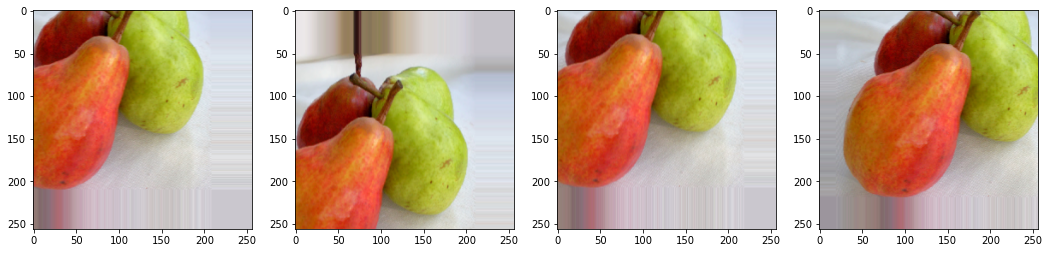

In [23]:
import matplotlib.pyplot as plt

datagen=ImageDataGenerator(
    #shear_range=30
    #zoom_range=0.3
    #horizontal_flip=True
    #rotation_range=30
    width_shift_range=0.2,
    height_shift_range=0.2
)
imagegen=datagen.flow_from_directory('augmentation/',batch_size=1)
fig, rows =plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

In [12]:
# Load InceptionV3 library
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Always clear the backend before training a model
backend.clear_session()
# InceptionV3 model and use the weights from imagenet
conv_base = InceptionV3(input_shape=(299, 299,3), weights = 'imagenet', #Useing the inception_v3 CNN that was trained on ImageNet data.  
                  include_top = False)
i = 0
for layer in conv_base.layers:
    if i <= 282:
        layer.trainable = False
    i += 1
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
# Connect the InceptionV3 output to the fully connected layers
InceptionV3_model = conv_base.output
pool = GlobalAveragePooling2D()(InceptionV3_model)
dense_1 = layers.Dense(512, activation = 'relu')(pool)
output = layers.Dense(30, activation = 'softmax')(dense_1)

In [16]:
# Create an example of the Archictecture to plot on a graph
model_example = models.Model(inputs=conv_base.input, outputs=output)
# plot graph
plot_model(model_example)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
# Define/Create the model for training
model_InceptionV3 = models.Model(inputs=conv_base.input, outputs=output)
# Compile the model with categorical crossentropy for the loss function and SGD for the optimizer with the learning
# rate at 1e-4 and momentum at 0.9
model_InceptionV3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])
model_InceptionV3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
for layer in model_InceptionV3.layers:
    layer.trainable = True
model_InceptionV3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])
model_InceptionV3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
# Import from tensorflow the module to read the GPU device and then print
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18142170008154460239
]


Epoch 1/10
49/49 [==============================] - 201s 4s/step - loss: 2.1851 - accuracy: 0.4653 - val_loss: 2.6719 - val_accuracy: 0.2487
Epoch 2/10
49/49 [==============================] - 202s 4s/step - loss: 2.1616 - accuracy: 0.4807 - val_loss: 2.6632 - val_accuracy: 0.2539
Epoch 3/10
49/49 [==============================] - 202s 4s/step - loss: 2.1455 - accuracy: 0.4653 - val_loss: 2.6548 - val_accuracy: 0.2383
Epoch 4/10
49/49 [==============================] - 204s 4s/step - loss: 2.1205 - accuracy: 0.4769 - val_loss: 2.6443 - val_accuracy: 0.2539
Epoch 5/10
49/49 [==============================] - 203s 4s/step - loss: 2.1149 - accuracy: 0.4769 - val_loss: 2.6374 - val_accuracy: 0.2539
Epoch 6/10
49/49 [==============================] - 204s 4s/step - loss: 2.0924 - accuracy: 0.4910 - val_loss: 2.6328 - val_accuracy: 0.2642
Epoch 7/10
49/49 [==============================] - 203s 4s/step - loss: 2.0974 - accuracy: 0.4756 - val_loss: 2.6265 - val_accuracy: 0.2746
Epoch 8/10
49

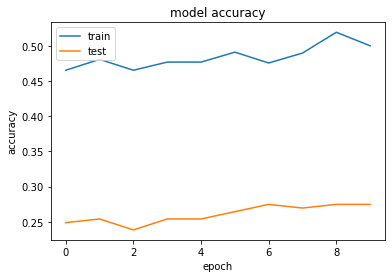

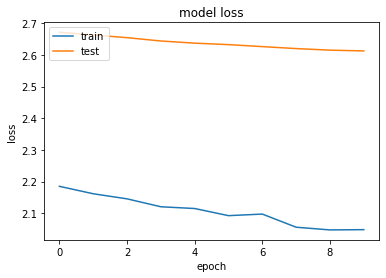

In [30]:
# Execute the model with fit_generator within the while loop utilizing the discovered GPU
import tensorflow as tf
import matplotlib.pyplot as plt
import time

start = time.time()
with tf.device("/device:CPU:0"):
    history = model_InceptionV3.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights = True)])
end = time.time()
print(f"Runtime of the program is {end - start}")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
a = history.history['accuracy'].copy()
b = history.history['val_accuracy'].copy()
c = history.history['loss'].copy()
d = history.history['val_loss'].copy()

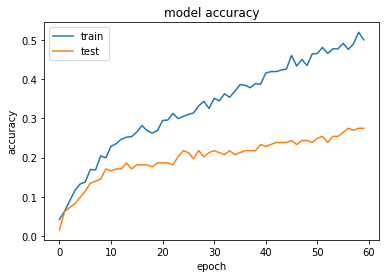

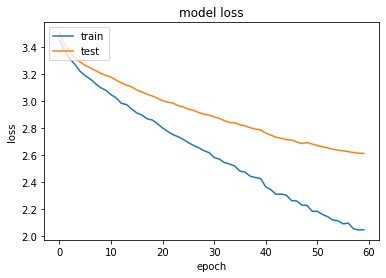

In [31]:
a = a + history.history['accuracy']
b = b + history.history['val_accuracy']
c = c + history.history['loss']
d = d + history.history['val_loss']
# summarize history for accuracy
plt.plot(a)
plt.plot(b)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(c)
plt.plot(d)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the test accuracy and test loss of the model
test_loss, test_acc = model_InceptionV3.evaluate(test_generator)
print('Model testing accuracy/testing loss:', test_acc, " ", test_loss)

#Confution Matrix and Classification Report
Y_pred = model_InceptionV3.predict(test_generator, 193 // 16+1)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['acerolas','apples','apricots','avocados','bananas','blackberries','blueberries','cantaloupes','cherries','coconuts','figs','grapefruits','grapes','guava','kiwifruit','lemons','limes','mangos','olives','oranges','passionfruit','peaches','pears','pineapples','plums','pomegranates','raspberries','strawberries','tomatoes','watermelons']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

13/13 [==============================] - 27s 2s/step - loss: 2.6129 - accuracy: 0.2746
Model testing accuracy/testing loss: 0.2746114134788513   2.612901210784912
[26 27 26  5 28  6 17 17 28  6  1  0  8 24 27  4 17  4 17 28 22 17 24 27
 13 15  4  4  4  4  5  5  5 12  6  5 27  5 27  5  8  6  6  6 24  7  7  7
 19 28  8  8  9  5 24  5  8  9 24 22 26 12 15 13 11 15 22  9 22 10 12 12
 27 12  6  5 13 19 12  0  1 11 26 14  1 11 14  6 14  4  4  4  4 17 19  0
 28 12 13  3 26  9  9  3 11 17  3 28 28  6  6  5 24  1  3  0 28  6 26 19
 12  4 14 19  7 14 23 17 13 15  9 28 21 27 14 19  7 17  4 22 23 23 23 12
 23  1  1 24 28 25 25 14 14 14 27  5 25  1 14 27 26 26 26 14 28 28  5 12
  9 27 27  5 26 27 27 27 27  1  1 28 28 28 26 28  1 12  8  9 12 13 26 26
 11]
Confusion Matrix
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 0]
 [1 1 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 1 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

C:\Users\asus\Anaconda3\envs\bsc-project\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\Anaconda3\envs\bsc-project\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\Anaconda3\envs\bsc-project\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# serialize to JSON
json_file = model_InceptionV3.to_json()
with open("C:/Users/asus/Documents/Bachelor Project/bsc project/Inception_no_aug_60.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model_InceptionV3.save_weights("Inception_no_aug_60.h5")

In [139]:
from tensorflow.keras.models import model_from_json

# load json and create model
file = open("C:/Users/asus/Documents/Bachelor Project/bsc project/model.json", 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("model.h5")

loaded_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

model_InceptionV3 = loaded_model

In [144]:
import cv2
from numpy import asarray

dic = test_generator.class_indices
key_list = list(dic.keys())
val_list = list(dic.values())

img = cv2.imread('C:/Users/asus/Documents/Bachelor Project/bsc project/Test/lemons/0.jpg')
img = cv2.resize(img, (299,299))
pixels = asarray(img)
pixels = pixels.astype('float32')
pixels /= 255.0
img = np.expand_dims(pixels, axis=0)

position = val_list.index(np.argmax(model_InceptionV3.predict(img).tolist()[0], axis=0))
print(key_list[position])

lemons
